<a href="https://colab.research.google.com/github/DanteAgarwal/meta_heuristics_optimzation_algorithm/blob/main/tlbo_cso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import random
import time
import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate


def ClearDups(Population, PopSize, dim, MaxParValue, MinParValue):
    for i in range(PopSize):
        Chrom1 = np.sort(Population[i, :])
        for j in range(i + 1, PopSize):
            Chrom2 = np.sort(Population[j, :])
            if Chrom1 is Chrom2:
                parnum = np.ceil(dim * random.random())
                Population[j, parnum] = MinParValue + (MaxParValue - MinParValue) * random.random()
    return Population


def simplebounds(s, Lb, Ub):
    # % Apply the lower bound
    ns_tmp = np.array(s)
    I = ns_tmp < Lb
    ns_tmp[I] = Lb

    # % Apply the upper bounds
    J = ns_tmp > Ub
    ns_tmp[J] = Ub
    # % Update this new move
    return ns_tmp


def sigmoid(x):
    return 1 / (1 + math.exp(-x))


def TLBO_CSO(objf, lb, ub, dim, PopSize, iters):
    # Initializing the parameters with default values
    Keep = 2

    Dest_pos = np.zeros(dim)
    Dest_score = float("inf")

    fit = np.zeros(PopSize)
    EliteSolution = np.zeros((Keep, dim))
    EliteCost = np.zeros(Keep)
    Island = np.zeros((PopSize, dim))
    mu = np.zeros(PopSize)
    lambda1 = np.zeros(PopSize)
    MinCost = np.zeros(iters)
    Bestpos = np.zeros(dim)

    # Initializing BBO parameters
    pmutate = 0.01  # initial mutation probability
    # elitism parameter: how many of the best habitats to keep from one generation to the next

    Positions = np.random.uniform(0, 1, (PopSize, dim)) * (ub - lb) + lb
    positions = np.random.choice([0, 1], size=(PopSize, dim))

    # Initializing Population
    pos = np.random.uniform(0, 1, (PopSize, dim)) * (ub - lb) + lb

    # Calculate objective function for each particle
    for i in range(PopSize):
        # Performing the bound checking
        pos[i, :] = np.clip(pos[i, :], lb, ub)
        fitness = objf(pos[i, :])
        fit[i] = fitness

    # Updating Dest_pos
    for i in range(0, PopSize):

        # Return back the search agents that go beyond the boundaries of the search space
        Positions[i, :] = np.clip(Positions[i, :], lb, ub)

        # Calculate objective function for each search agent
        fitness = objf(Positions[i, :])

        if fitness < Dest_score:
            Dest_score = fitness  # Update Dest_Score
            Dest_pos = Positions[i, :].copy()

    # Calculating the mu and lambda
    for i in range(PopSize):
        mu[i] = (PopSize + 1 - (i)) / (PopSize + 1)
        lambda1[i] = 1 - mu[i]

    print("TLBO_CSO is optimizing  \"" + objf.__name__ + "\"")

    timerStart = time.time()

    # Defining the loop
    for l in range(iters):
        # Defining the Elite Solutions
        for j in range(Keep):
            EliteSolution[j, :] = pos[j, :]
            EliteCost[j] = fit[j]

        for i in range(PopSize):
            lambda1[i] = 1 - mu[i]
            mu[i] = (PopSize + 1 - (i)) / (PopSize + 1)

        # Performing Migration operator
        for k in range(PopSize):
            for j in range(dim):
                if random.random() < lambda1[k]:
                    # Performing Roulette Wheel
                    RandomNum = random.random() * sum(mu)
                    Select = mu[1]
                    SelectIndex = 0
                    while (RandomNum > Select) and (SelectIndex < (PopSize - 1)):
                        SelectIndex = SelectIndex + 1
                        Select = Select + mu[SelectIndex]

                    Island[k, j] = pos[SelectIndex, j]
                else:
                    Island[k, j] = pos[k, j]
        a = 2
        r1 = a - l * ((a) / iters)

        for p in range(round(PopSize / 2), PopSize):
            for j in range(dim):

                r2 = (2 * np.pi) * random.random()
                r3 = 2 * random.random()
                r4 = random.random()

                if (r4 < 0.5):
                    Island[p, j] = Island[p, j] + r1 * math.sin(r2) * abs(r3 * Dest_pos[j] - Island[p, j])
                else:
                    Island[p, j] = Island[p, j] + r1 * math.cos(r2) * abs(r3 * Dest_pos[j] - Island[p, j])

        # Performing Mutation
        for k in range(PopSize):
            for parnum in range(dim):
                if pmutate > random.random():
                    Island[k, parnum] = lb + (ub - lb) * random.random()

        # Performing the bound checking
        for i in range(PopSize):
            Island[i, :] = np.clip(Island[i, :], lb, ub)

        # Replace the habitats with their new versions.
        for k in range(PopSize):
            pos[k, :] = Island[k, :]

        # Calculate objective function for each individual
        for i in range(PopSize):
            fitness = objf(pos[i, :])
            fit[i] = fitness

        # Sort the population on fitness
        I = np.argsort(fit)
        pos = pos[I, :]

        # Replacing the individual of population with EliteSolution
        for k in range(Keep):
            pos[(PopSize - 1) - k, :] = EliteSolution[k, :]
            fit[(PopSize - 1)] = EliteCost[k]

        # Removing the duplicate individuals
        pos = ClearDups(pos, PopSize, dim, ub, lb)

        # Calculate objective function for each individual
        for i in range(PopSize):
            fitness = objf(pos[i, :])
            fit[i] = fitness

            s = Positions[i, :]

            Positions[i] = simplebounds(s, lb, ub)

            rand = random.random()
            if (sigmoid(Positions[i - 1, j]) >= rand):
                positions[i, j] = 1
            else:
                positions[i, j] = 0

        # Sort the fitness
        fitness_sorted = np.sort(fit)

        # Sort the population on fitness
        I = np.argsort(fit)
        pos = pos[I, :]

        # Updating Dest_pos
        for i in range(0, PopSize):

            # Return back the search agents that go beyond the boundaries of the search space
            Positions[i, :] = np.clip(Positions[i, :], lb, ub)

            # Calculate objective function for each search agent
            fitness = objf(Positions[i, :])

            if fitness < Dest_score:
                Dest_score = fitness  # Update Dest_Score
                Dest_pos = Positions[i, :].copy()

        # Saving the best individual
        MinCost[l] = fit[1]
        Bestpos = pos[1, :]
        gBestScore = fit[1]

        # Displaying the best fitness of each iteration
        if (l % 1 == 0):
            print("TLBO_CSO is Optimizing at iteartion " + str(l))

    timerEnd = time.time()
    y1 = np.array(MinCost, dtype=np.longdouble)
    x1 = np.arange(0, iters, dtype=int) + 1
    print('Completed in', (timerEnd - timerStart))
    plt.plot(x1, y1, "o-")
    plt.xlabel("Iterations")
    plt.ylabel("Fitness")
    plt.title(
        f"Convergence_curve TLBO_CSO for parameter including population "
        f"{PopSize}, \niteration {iters},and  max fitness is:{min(MinCost)}")
    save_results_to = '/content/drive/MyDrive/features/TLBO_CSO' + '/With Population ' + str(
        PopSize) + '/Iteration ' + str(iters) + '/Convergence Curve/'
    plt.savefig(save_results_to + 'Convergence Curve for Iteration' + str(iters), dpi=800)
    plt.show()
    opts = {"p": positions, 'c': min(MinCost)}

    return opts


In [ ]:
def ackley(d, *, a=20, b=0.2, c=2 * np.pi):
    sum_part1 = np.sum([x ** 2 for x in d])
    part1 = -1.0 * a * np.exp(-1.0 * b * np.sqrt((1.0 / len(d)) * sum_part1))

    sum_part2 = np.sum([np.cos(c * x) for x in d])
    part2 = -1.0 * np.exp((1.0 / len(d)) * sum_part2)
    return (a + np.exp(1) + part1 + part2)

at poulation of 5
at poulation of 5
 at iteration of 100
TLBO_CSO is optimizing  "ackley"
TLBO_CSO is Optimizing at iteartion 0
TLBO_CSO is Optimizing at iteartion 1
TLBO_CSO is Optimizing at iteartion 2
TLBO_CSO is Optimizing at iteartion 3
TLBO_CSO is Optimizing at iteartion 4
TLBO_CSO is Optimizing at iteartion 5
TLBO_CSO is Optimizing at iteartion 6
TLBO_CSO is Optimizing at iteartion 7
TLBO_CSO is Optimizing at iteartion 8
TLBO_CSO is Optimizing at iteartion 9
TLBO_CSO is Optimizing at iteartion 10
TLBO_CSO is Optimizing at iteartion 11
TLBO_CSO is Optimizing at iteartion 12
TLBO_CSO is Optimizing at iteartion 13
TLBO_CSO is Optimizing at iteartion 14
TLBO_CSO is Optimizing at iteartion 15
TLBO_CSO is Optimizing at iteartion 16
TLBO_CSO is Optimizing at iteartion 17
TLBO_CSO is Optimizing at iteartion 18
TLBO_CSO is Optimizing at iteartion 19
TLBO_CSO is Optimizing at iteartion 20
TLBO_CSO is Optimizing at iteartion 21
TLBO_CSO is Optimizing at iteartion 22
TLBO_CSO is Optimizing 

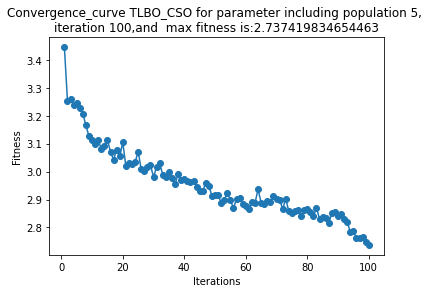

[2, 3, 5, 6, 7, 9, 11, 12, 13, 16, 17, 18, 24, 29, 30, 40, 42, 44, 46, 51, 52, 55, 56, 61, 65, 66, 70, 71, 72, 73, 77, 78, 82, 85, 86, 87, 89, 91, 92, 93, 94, 95, 96, 98, 101, 102, 106, 108, 113, 114, 116, 118, 119, 120, 121, 123, 125, 126, 128, 130, 131, 134, 135, 138, 140, 142, 144, 147, 148, 150, 156, 161, 165, 167, 168, 169, 172, 174, 180, 186, 188, 189, 195, 196, 197, 199, 202, 203, 205, 207, 208, 209, 212]
93
[213, 100, 5, array([  2,   3,   5,   6,   7,   9,  11,  12,  13,  16,  17,  18,  24,
        29,  30,  40,  42,  44,  46,  51,  52,  55,  56,  61,  65,  66,
        70,  71,  72,  73,  77,  78,  82,  85,  86,  87,  89,  91,  92,
        93,  94,  95,  96,  98, 101, 102, 106, 108, 113, 114, 116, 118,
       119, 120, 121, 123, 125, 126, 128, 130, 131, 134, 135, 138, 140,
       142, 144, 147, 148, 150, 156, 161, 165, 167, 168, 169, 172, 174,
       180, 186, 188, 189, 195, 196, 197, 199, 202, 203, 205, 207, 208,
       209, 212]), 2.737419834654463, 93]
at poulation of 5
 at

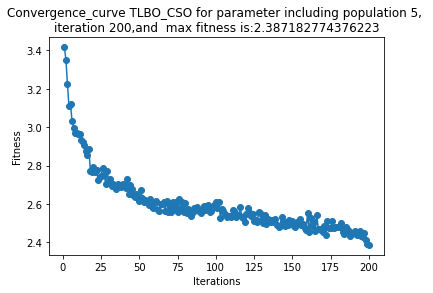

[1, 4, 6, 7, 8, 10, 11, 13, 14, 16, 17, 18, 20, 21, 22, 24, 25, 29, 30, 31, 38, 40, 41, 43, 47, 48, 50, 53, 55, 56, 61, 63, 64, 69, 70, 75, 79, 80, 81, 83, 84, 88, 91, 94, 96, 100, 102, 104, 105, 106, 107, 108, 110, 111, 113, 115, 118, 120, 121, 122, 124, 125, 126, 129, 132, 133, 135, 136, 138, 139, 140, 142, 143, 144, 145, 147, 149, 150, 152, 154, 156, 157, 158, 160, 163, 164, 166, 169, 173, 175, 176, 178, 182, 183, 186, 188, 189, 193, 195, 197, 198, 199, 201, 203, 208, 211, 212]
107
[213, 200, 5, array([  1,   4,   6,   7,   8,  10,  11,  13,  14,  16,  17,  18,  20,
        21,  22,  24,  25,  29,  30,  31,  38,  40,  41,  43,  47,  48,
        50,  53,  55,  56,  61,  63,  64,  69,  70,  75,  79,  80,  81,
        83,  84,  88,  91,  94,  96, 100, 102, 104, 105, 106, 107, 108,
       110, 111, 113, 115, 118, 120, 121, 122, 124, 125, 126, 129, 132,
       133, 135, 136, 138, 139, 140, 142, 143, 144, 145, 147, 149, 150,
       152, 154, 156, 157, 158, 160, 163, 164, 166, 169, 173, 17

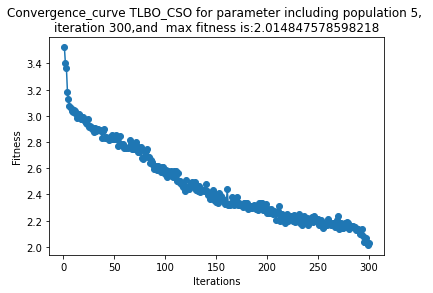

[3, 5, 6, 8, 9, 11, 14, 17, 18, 19, 20, 24, 25, 26, 28, 29, 31, 32, 33, 36, 37, 38, 42, 45, 46, 48, 49, 51, 52, 56, 58, 60, 61, 62, 64, 66, 68, 71, 72, 76, 80, 81, 82, 85, 87, 92, 95, 98, 106, 107, 108, 110, 112, 116, 119, 121, 122, 123, 128, 130, 131, 132, 134, 135, 136, 137, 138, 139, 141, 143, 144, 151, 153, 154, 156, 158, 160, 163, 166, 171, 175, 177, 179, 180, 182, 192, 193, 194, 195, 196, 197, 199, 201, 202, 204, 206, 207, 208, 209, 210, 212]
101
[213, 300, 5, array([  3,   5,   6,   8,   9,  11,  14,  17,  18,  19,  20,  24,  25,
        26,  28,  29,  31,  32,  33,  36,  37,  38,  42,  45,  46,  48,
        49,  51,  52,  56,  58,  60,  61,  62,  64,  66,  68,  71,  72,
        76,  80,  81,  82,  85,  87,  92,  95,  98, 106, 107, 108, 110,
       112, 116, 119, 121, 122, 123, 128, 130, 131, 132, 134, 135, 136,
       137, 138, 139, 141, 143, 144, 151, 153, 154, 156, 158, 160, 163,
       166, 171, 175, 177, 179, 180, 182, 192, 193, 194, 195, 196, 197,
       199, 201, 202, 204

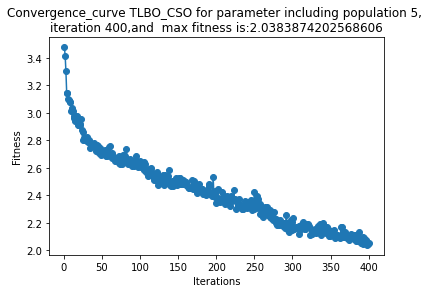

[1, 2, 6, 8, 9, 11, 13, 14, 15, 16, 18, 19, 20, 23, 24, 25, 26, 28, 29, 32, 38, 39, 41, 42, 44, 45, 47, 50, 54, 55, 60, 61, 67, 68, 70, 72, 73, 74, 78, 80, 85, 86, 88, 91, 94, 97, 101, 102, 104, 106, 107, 112, 115, 116, 117, 120, 126, 130, 132, 133, 135, 137, 139, 141, 142, 143, 144, 145, 146, 148, 149, 150, 152, 154, 156, 160, 165, 167, 169, 175, 177, 178, 180, 185, 191, 192, 193, 197, 198, 199, 201, 204, 206, 207, 210, 212]
96
[213, 400, 5, array([  1,   2,   6,   8,   9,  11,  13,  14,  15,  16,  18,  19,  20,
        23,  24,  25,  26,  28,  29,  32,  38,  39,  41,  42,  44,  45,
        47,  50,  54,  55,  60,  61,  67,  68,  70,  72,  73,  74,  78,
        80,  85,  86,  88,  91,  94,  97, 101, 102, 104, 106, 107, 112,
       115, 116, 117, 120, 126, 130, 132, 133, 135, 137, 139, 141, 142,
       143, 144, 145, 146, 148, 149, 150, 152, 154, 156, 160, 165, 167,
       169, 175, 177, 178, 180, 185, 191, 192, 193, 197, 198, 199, 201,
       204, 206, 207, 210, 212]), 2.0383874202568

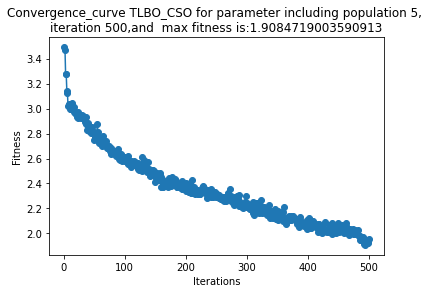

[0, 1, 3, 4, 6, 8, 9, 11, 12, 14, 15, 17, 18, 21, 27, 28, 29, 30, 34, 35, 36, 38, 41, 44, 45, 49, 52, 53, 54, 55, 58, 61, 62, 63, 68, 69, 70, 71, 72, 75, 77, 79, 81, 82, 84, 85, 86, 87, 88, 90, 91, 93, 94, 95, 96, 97, 99, 102, 103, 104, 105, 107, 108, 112, 114, 116, 118, 119, 122, 123, 124, 127, 128, 131, 132, 134, 135, 136, 142, 143, 146, 147, 149, 150, 153, 156, 159, 164, 166, 167, 171, 172, 173, 176, 177, 179, 181, 182, 183, 186, 188, 189, 190, 191, 194, 199, 200, 202, 203, 204, 206, 210]
112
[213, 500, 5, array([  0,   1,   3,   4,   6,   8,   9,  11,  12,  14,  15,  17,  18,
        21,  27,  28,  29,  30,  34,  35,  36,  38,  41,  44,  45,  49,
        52,  53,  54,  55,  58,  61,  62,  63,  68,  69,  70,  71,  72,
        75,  77,  79,  81,  82,  84,  85,  86,  87,  88,  90,  91,  93,
        94,  95,  96,  97,  99, 102, 103, 104, 105, 107, 108, 112, 114,
       116, 118, 119, 122, 123, 124, 127, 128, 131, 132, 134, 135, 136,
       142, 143, 146, 147, 149, 150, 153, 156, 159, 1

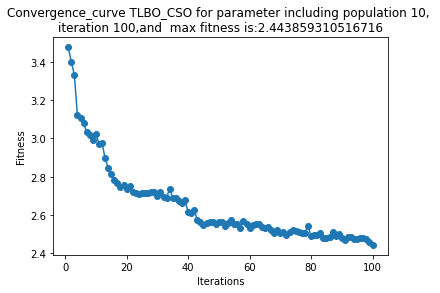

[0, 1, 2, 4, 6, 7, 8, 10, 11, 14, 17, 18, 19, 21, 22, 26, 27, 32, 34, 35, 36, 42, 45, 46, 47, 48, 50, 53, 54, 57, 58, 61, 65, 66, 73, 76, 78, 81, 82, 88, 90, 91, 92, 93, 97, 99, 101, 102, 104, 106, 108, 110, 112, 113, 115, 116, 117, 118, 119, 123, 124, 125, 128, 130, 131, 135, 137, 138, 141, 143, 144, 147, 148, 149, 150, 151, 153, 154, 157, 158, 159, 162, 164, 166, 169, 170, 171, 177, 178, 182, 183, 184, 185, 186, 188, 189, 191, 192, 196, 198, 200, 202, 205, 208, 210, 212]
106
[213, 100, 10, array([  0,   1,   2,   4,   6,   7,   8,  10,  11,  14,  17,  18,  19,
        21,  22,  26,  27,  32,  34,  35,  36,  42,  45,  46,  47,  48,
        50,  53,  54,  57,  58,  61,  65,  66,  73,  76,  78,  81,  82,
        88,  90,  91,  92,  93,  97,  99, 101, 102, 104, 106, 108, 110,
       112, 113, 115, 116, 117, 118, 119, 123, 124, 125, 128, 130, 131,
       135, 137, 138, 141, 143, 144, 147, 148, 149, 150, 151, 153, 154,
       157, 158, 159, 162, 164, 166, 169, 170, 171, 177, 178, 182, 183,

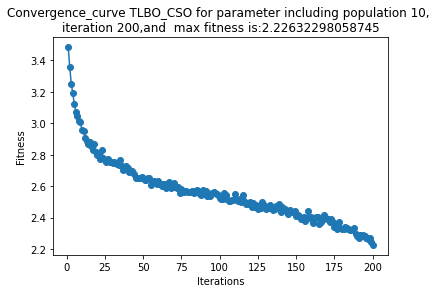

[1, 3, 6, 7, 8, 9, 11, 13, 18, 19, 22, 23, 25, 29, 38, 39, 40, 43, 44, 49, 51, 54, 56, 57, 58, 59, 60, 62, 63, 65, 66, 67, 68, 69, 70, 74, 77, 78, 80, 85, 87, 88, 90, 91, 92, 93, 95, 96, 97, 98, 99, 100, 101, 103, 105, 106, 107, 108, 110, 118, 119, 121, 122, 124, 125, 127, 128, 132, 133, 134, 137, 138, 139, 141, 142, 143, 145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 157, 161, 162, 163, 165, 166, 169, 171, 173, 174, 175, 177, 178, 180, 182, 184, 185, 187, 188, 192, 195, 197, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 211]
119
[213, 200, 10, array([  1,   3,   6,   7,   8,   9,  11,  13,  18,  19,  22,  23,  25,
        29,  38,  39,  40,  43,  44,  49,  51,  54,  56,  57,  58,  59,
        60,  62,  63,  65,  66,  67,  68,  69,  70,  74,  77,  78,  80,
        85,  87,  88,  90,  91,  92,  93,  95,  96,  97,  98,  99, 100,
       101, 103, 105, 106, 107, 108, 110, 118, 119, 121, 122, 124, 125,
       127, 128, 132, 133, 134, 137, 138, 139, 141, 142, 143, 145, 146,
       147

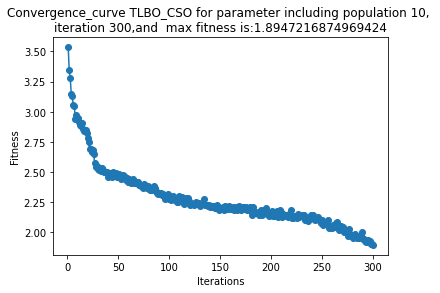

[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 14, 17, 18, 19, 22, 25, 27, 28, 29, 31, 34, 35, 36, 37, 38, 41, 43, 44, 50, 51, 52, 53, 55, 57, 58, 59, 62, 63, 64, 66, 68, 71, 73, 74, 75, 76, 77, 78, 80, 81, 82, 88, 91, 94, 95, 97, 98, 103, 104, 105, 106, 108, 109, 111, 113, 116, 119, 120, 123, 124, 125, 126, 127, 128, 131, 134, 135, 136, 138, 139, 141, 143, 144, 146, 147, 148, 156, 159, 160, 165, 167, 168, 169, 170, 171, 172, 173, 180, 185, 187, 188, 190, 192, 193, 195, 196, 197, 200, 203, 207, 208, 211]
112
[213, 300, 10, array([  1,   2,   3,   4,   5,   6,   8,   9,  10,  11,  14,  17,  18,
        19,  22,  25,  27,  28,  29,  31,  34,  35,  36,  37,  38,  41,
        43,  44,  50,  51,  52,  53,  55,  57,  58,  59,  62,  63,  64,
        66,  68,  71,  73,  74,  75,  76,  77,  78,  80,  81,  82,  88,
        91,  94,  95,  97,  98, 103, 104, 105, 106, 108, 109, 111, 113,
       116, 119, 120, 123, 124, 125, 126, 127, 128, 131, 134, 135, 136,
       138, 139, 141, 143, 144, 146, 147, 148, 156, 1

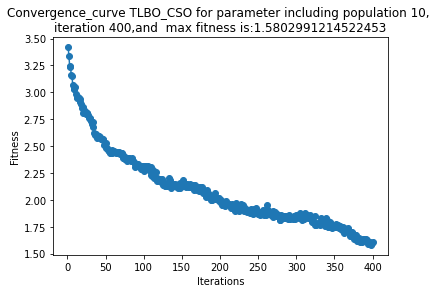

[0, 2, 3, 4, 6, 7, 8, 10, 12, 14, 16, 17, 20, 23, 26, 27, 29, 30, 31, 32, 33, 36, 38, 41, 55, 56, 59, 60, 61, 62, 64, 68, 70, 75, 76, 77, 78, 80, 81, 82, 84, 85, 88, 89, 91, 92, 95, 98, 99, 100, 101, 104, 105, 107, 109, 110, 111, 112, 116, 118, 121, 123, 125, 126, 128, 129, 131, 134, 135, 136, 142, 144, 145, 146, 147, 148, 151, 152, 153, 158, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 183, 185, 187, 192, 193, 196, 198, 199, 200, 204, 205, 206, 207, 210, 211]
115
[213, 400, 10, array([  0,   2,   3,   4,   6,   7,   8,  10,  12,  14,  16,  17,  20,
        23,  26,  27,  29,  30,  31,  32,  33,  36,  38,  41,  55,  56,
        59,  60,  61,  62,  64,  68,  70,  75,  76,  77,  78,  80,  81,
        82,  84,  85,  88,  89,  91,  92,  95,  98,  99, 100, 101, 104,
       105, 107, 109, 110, 111, 112, 116, 118, 121, 123, 125, 126, 128,
       129, 131, 134, 135, 136, 142, 144, 145, 146, 147, 148, 151, 152,
       153, 158, 160, 161, 16

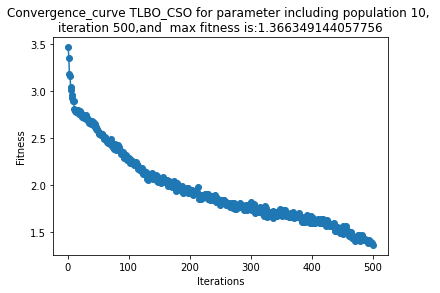

[1, 3, 4, 5, 10, 11, 13, 14, 18, 21, 22, 29, 33, 34, 36, 37, 39, 41, 45, 51, 52, 56, 59, 60, 62, 63, 65, 66, 68, 70, 72, 74, 76, 78, 79, 80, 83, 84, 86, 87, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 102, 103, 104, 106, 107, 109, 110, 111, 112, 114, 117, 118, 121, 123, 126, 127, 128, 130, 131, 132, 133, 134, 135, 136, 138, 141, 142, 143, 150, 156, 158, 164, 168, 172, 174, 176, 178, 179, 180, 181, 187, 188, 189, 191, 192, 194, 195, 196, 197, 198, 200, 203, 205, 207, 208, 209, 212]
107
[213, 500, 10, array([  1,   3,   4,   5,  10,  11,  13,  14,  18,  21,  22,  29,  33,
        34,  36,  37,  39,  41,  45,  51,  52,  56,  59,  60,  62,  63,
        65,  66,  68,  70,  72,  74,  76,  78,  79,  80,  83,  84,  86,
        87,  90,  92,  93,  94,  95,  96,  97,  98,  99, 100, 102, 103,
       104, 106, 107, 109, 110, 111, 112, 114, 117, 118, 121, 123, 126,
       127, 128, 130, 131, 132, 133, 134, 135, 136, 138, 141, 142, 143,
       150, 156, 158, 164, 168, 172, 174, 176, 178, 179, 180, 181,

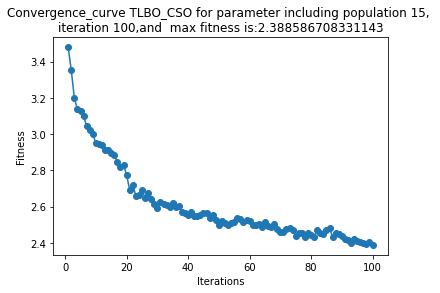

[0, 1, 4, 7, 9, 11, 13, 16, 18, 20, 21, 22, 23, 24, 27, 28, 31, 32, 34, 36, 37, 39, 40, 44, 48, 50, 53, 54, 55, 57, 58, 60, 61, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 79, 83, 84, 85, 88, 89, 93, 94, 95, 96, 99, 100, 103, 104, 105, 106, 108, 109, 110, 112, 114, 118, 119, 120, 122, 126, 127, 128, 129, 130, 132, 133, 135, 136, 138, 139, 143, 144, 147, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 166, 170, 172, 173, 175, 176, 180, 181, 182, 184, 185, 192, 193, 195, 198, 199, 200, 202, 203, 205, 207, 208, 210, 212]
123
[213, 100, 15, array([  0,   1,   4,   7,   9,  11,  13,  16,  18,  20,  21,  22,  23,
        24,  27,  28,  31,  32,  34,  36,  37,  39,  40,  44,  48,  50,
        53,  54,  55,  57,  58,  60,  61,  63,  65,  66,  67,  68,  69,
        70,  71,  72,  73,  74,  76,  77,  79,  83,  84,  85,  88,  89,
        93,  94,  95,  96,  99, 100, 103, 104, 105, 106, 108, 109, 110,
       112, 114, 118, 119, 120, 122, 126, 127, 128, 129, 130, 132, 

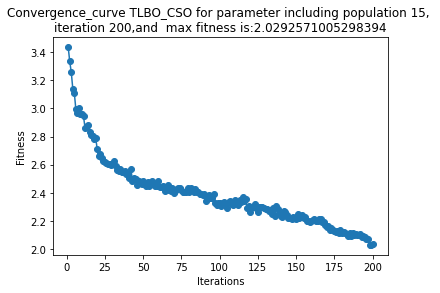

[1, 2, 3, 4, 8, 9, 13, 14, 18, 19, 20, 21, 26, 31, 33, 35, 38, 40, 41, 43, 44, 45, 47, 48, 51, 52, 54, 56, 57, 63, 64, 66, 67, 68, 69, 70, 74, 77, 78, 84, 85, 86, 87, 88, 91, 92, 93, 94, 97, 99, 100, 104, 106, 110, 111, 112, 114, 118, 119, 120, 121, 126, 129, 130, 134, 136, 137, 138, 144, 145, 146, 148, 150, 151, 153, 155, 158, 159, 160, 162, 164, 165, 167, 170, 172, 174, 175, 177, 179, 184, 186, 187, 188, 194, 198, 202, 203, 204, 206, 207, 209, 211, 212]
103
[213, 200, 15, array([  1,   2,   3,   4,   8,   9,  13,  14,  18,  19,  20,  21,  26,
        31,  33,  35,  38,  40,  41,  43,  44,  45,  47,  48,  51,  52,
        54,  56,  57,  63,  64,  66,  67,  68,  69,  70,  74,  77,  78,
        84,  85,  86,  87,  88,  91,  92,  93,  94,  97,  99, 100, 104,
       106, 110, 111, 112, 114, 118, 119, 120, 121, 126, 129, 130, 134,
       136, 137, 138, 144, 145, 146, 148, 150, 151, 153, 155, 158, 159,
       160, 162, 164, 165, 167, 170, 172, 174, 175, 177, 179, 184, 186,
       187, 188, 

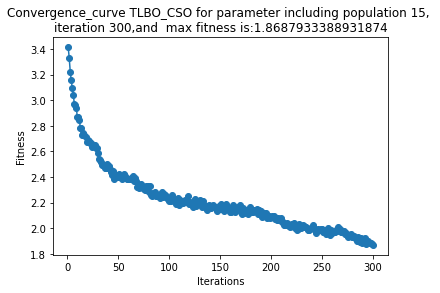

[2, 6, 8, 9, 15, 16, 22, 23, 24, 26, 27, 33, 37, 40, 41, 42, 43, 44, 45, 50, 51, 54, 55, 56, 57, 58, 60, 61, 62, 63, 68, 69, 70, 74, 76, 78, 79, 80, 81, 83, 88, 89, 90, 91, 93, 94, 96, 97, 99, 100, 102, 103, 105, 106, 110, 111, 112, 113, 115, 120, 121, 123, 125, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 142, 144, 147, 149, 152, 153, 157, 161, 163, 164, 165, 168, 169, 170, 171, 174, 175, 178, 180, 181, 183, 184, 186, 187, 189, 192, 193, 196, 198, 199, 203, 204, 206, 209, 210, 211, 212]
112
[213, 300, 15, array([  2,   6,   8,   9,  15,  16,  22,  23,  24,  26,  27,  33,  37,
        40,  41,  42,  43,  44,  45,  50,  51,  54,  55,  56,  57,  58,
        60,  61,  62,  63,  68,  69,  70,  74,  76,  78,  79,  80,  81,
        83,  88,  89,  90,  91,  93,  94,  96,  97,  99, 100, 102, 103,
       105, 106, 110, 111, 112, 113, 115, 120, 121, 123, 125, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 142, 144, 147,
       149, 152, 153, 157, 161, 163, 164,

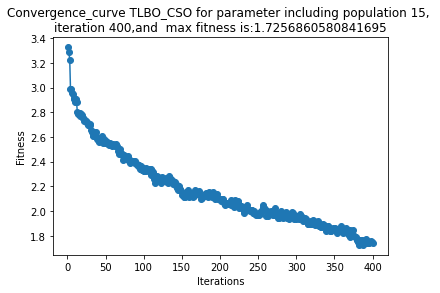

[0, 1, 2, 3, 4, 5, 9, 10, 11, 12, 14, 15, 23, 24, 25, 26, 29, 33, 36, 39, 41, 43, 45, 47, 51, 52, 53, 54, 55, 56, 62, 64, 65, 68, 70, 71, 73, 75, 79, 80, 83, 84, 85, 87, 88, 89, 91, 92, 93, 94, 96, 100, 103, 108, 110, 113, 114, 115, 116, 117, 119, 120, 123, 124, 127, 129, 130, 131, 132, 133, 135, 138, 140, 141, 142, 144, 145, 146, 148, 155, 156, 158, 161, 163, 164, 165, 166, 168, 170, 171, 173, 174, 177, 178, 179, 180, 181, 182, 183, 184, 185, 187, 188, 193, 194, 196, 197, 198, 200, 201, 202, 203, 206, 208, 210, 211, 212]
117
[213, 400, 15, array([  0,   1,   2,   3,   4,   5,   9,  10,  11,  12,  14,  15,  23,
        24,  25,  26,  29,  33,  36,  39,  41,  43,  45,  47,  51,  52,
        53,  54,  55,  56,  62,  64,  65,  68,  70,  71,  73,  75,  79,
        80,  83,  84,  85,  87,  88,  89,  91,  92,  93,  94,  96, 100,
       103, 108, 110, 113, 114, 115, 116, 117, 119, 120, 123, 124, 127,
       129, 130, 131, 132, 133, 135, 138, 140, 141, 142, 144, 145, 146,
       148, 155, 156,

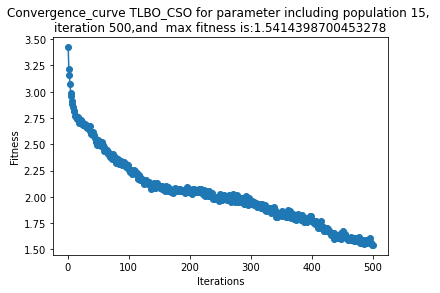

[1, 3, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 25, 26, 30, 31, 33, 34, 35, 36, 41, 44, 45, 48, 50, 51, 52, 53, 55, 61, 64, 66, 67, 68, 69, 71, 73, 74, 75, 76, 77, 78, 81, 86, 87, 88, 90, 91, 100, 105, 106, 107, 110, 112, 113, 114, 115, 116, 117, 120, 125, 126, 127, 129, 130, 135, 137, 138, 142, 143, 146, 148, 149, 152, 153, 154, 155, 156, 159, 162, 163, 164, 165, 167, 169, 170, 171, 172, 173, 174, 175, 176, 179, 180, 181, 182, 185, 189, 190, 193, 194, 195, 197, 201, 202, 203, 204, 208, 212]
115
[213, 500, 15, array([  1,   3,   5,   7,   8,   9,  10,  12,  13,  14,  15,  16,  17,
        18,  19,  20,  22,  23,  25,  26,  30,  31,  33,  34,  35,  36,
        41,  44,  45,  48,  50,  51,  52,  53,  55,  61,  64,  66,  67,
        68,  69,  71,  73,  74,  75,  76,  77,  78,  81,  86,  87,  88,
        90,  91, 100, 105, 106, 107, 110, 112, 113, 114, 115, 116, 117,
       120, 125, 126, 127, 129, 130, 135, 137, 138, 142, 143, 146, 148,
       149, 152, 153, 154, 155, 1

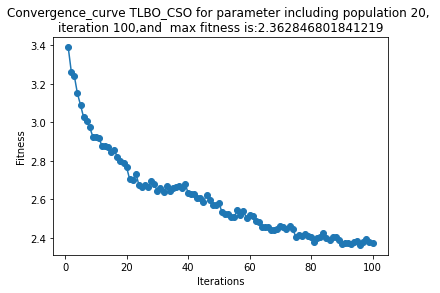

[1, 3, 5, 6, 7, 8, 9, 10, 12, 13, 17, 18, 20, 23, 26, 27, 30, 31, 32, 33, 36, 38, 40, 41, 43, 48, 49, 50, 51, 56, 57, 61, 63, 68, 72, 75, 76, 78, 81, 82, 83, 86, 89, 90, 92, 95, 98, 99, 101, 103, 105, 108, 109, 113, 115, 116, 119, 123, 125, 128, 131, 132, 134, 135, 136, 137, 138, 141, 144, 149, 153, 156, 159, 161, 163, 164, 165, 167, 169, 171, 173, 174, 175, 176, 177, 179, 180, 183, 186, 189, 191, 192, 193, 194, 195, 197, 198, 202, 206, 208, 209]
101
[213, 100, 20, array([  1,   3,   5,   6,   7,   8,   9,  10,  12,  13,  17,  18,  20,
        23,  26,  27,  30,  31,  32,  33,  36,  38,  40,  41,  43,  48,
        49,  50,  51,  56,  57,  61,  63,  68,  72,  75,  76,  78,  81,
        82,  83,  86,  89,  90,  92,  95,  98,  99, 101, 103, 105, 108,
       109, 113, 115, 116, 119, 123, 125, 128, 131, 132, 134, 135, 136,
       137, 138, 141, 144, 149, 153, 156, 159, 161, 163, 164, 165, 167,
       169, 171, 173, 174, 175, 176, 177, 179, 180, 183, 186, 189, 191,
       192, 193, 194, 195,

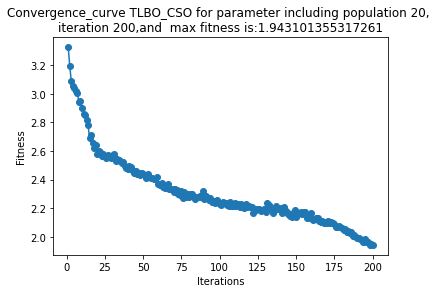

[0, 4, 7, 8, 10, 12, 14, 18, 19, 21, 22, 25, 30, 31, 36, 38, 40, 41, 45, 46, 47, 48, 49, 50, 53, 54, 56, 61, 62, 67, 68, 69, 71, 72, 73, 74, 75, 77, 78, 79, 80, 82, 84, 85, 90, 91, 94, 96, 100, 101, 102, 103, 104, 105, 106, 107, 109, 111, 118, 119, 121, 123, 124, 125, 127, 130, 134, 136, 138, 139, 140, 141, 142, 143, 144, 146, 147, 154, 155, 157, 159, 160, 165, 168, 169, 172, 173, 176, 177, 178, 183, 187, 192, 194, 195, 196, 198, 199, 200, 202, 204, 205, 211, 212]
104
[213, 200, 20, array([  0,   4,   7,   8,  10,  12,  14,  18,  19,  21,  22,  25,  30,
        31,  36,  38,  40,  41,  45,  46,  47,  48,  49,  50,  53,  54,
        56,  61,  62,  67,  68,  69,  71,  72,  73,  74,  75,  77,  78,
        79,  80,  82,  84,  85,  90,  91,  94,  96, 100, 101, 102, 103,
       104, 105, 106, 107, 109, 111, 118, 119, 121, 123, 124, 125, 127,
       130, 134, 136, 138, 139, 140, 141, 142, 143, 144, 146, 147, 154,
       155, 157, 159, 160, 165, 168, 169, 172, 173, 176, 177, 178, 183,
       1

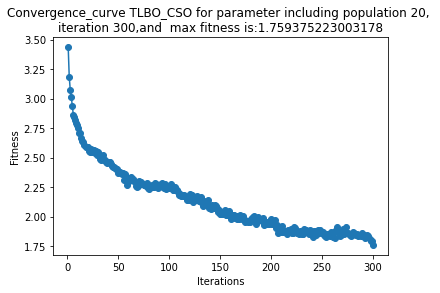

[0, 2, 7, 9, 11, 12, 14, 16, 18, 20, 21, 22, 26, 28, 30, 33, 40, 41, 43, 44, 47, 49, 51, 52, 53, 58, 59, 61, 63, 68, 70, 72, 73, 75, 78, 79, 82, 83, 87, 88, 89, 94, 95, 97, 98, 99, 101, 103, 107, 108, 109, 110, 112, 114, 115, 116, 125, 126, 127, 128, 129, 130, 133, 137, 138, 139, 141, 142, 143, 144, 146, 147, 150, 151, 153, 156, 157, 158, 160, 163, 167, 168, 169, 170, 172, 173, 174, 176, 177, 180, 185, 187, 188, 192, 195, 200, 201, 202, 204, 208, 210, 212]
102
[213, 300, 20, array([  0,   2,   7,   9,  11,  12,  14,  16,  18,  20,  21,  22,  26,
        28,  30,  33,  40,  41,  43,  44,  47,  49,  51,  52,  53,  58,
        59,  61,  63,  68,  70,  72,  73,  75,  78,  79,  82,  83,  87,
        88,  89,  94,  95,  97,  98,  99, 101, 103, 107, 108, 109, 110,
       112, 114, 115, 116, 125, 126, 127, 128, 129, 130, 133, 137, 138,
       139, 141, 142, 143, 144, 146, 147, 150, 151, 153, 156, 157, 158,
       160, 163, 167, 168, 169, 170, 172, 173, 174, 176, 177, 180, 185,
       187, 188,

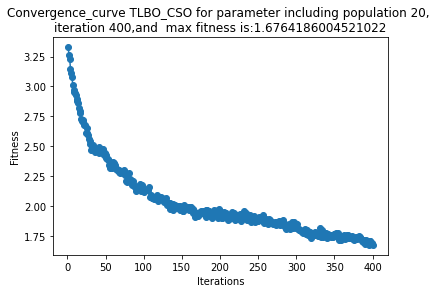

[0, 1, 2, 5, 6, 10, 11, 13, 18, 19, 20, 27, 32, 33, 38, 39, 40, 43, 45, 46, 47, 48, 54, 56, 57, 58, 61, 65, 66, 70, 72, 74, 76, 79, 82, 83, 84, 85, 87, 88, 90, 91, 94, 97, 99, 101, 103, 105, 106, 107, 108, 110, 111, 112, 115, 117, 119, 120, 126, 128, 129, 131, 133, 135, 136, 139, 144, 145, 147, 149, 152, 153, 157, 158, 160, 161, 162, 164, 165, 166, 167, 170, 173, 175, 177, 179, 182, 183, 186, 187, 188, 189, 190, 191, 192, 193, 196, 197, 198, 199, 200, 202, 203, 204, 205, 207, 208]
107
[213, 400, 20, array([  0,   1,   2,   5,   6,  10,  11,  13,  18,  19,  20,  27,  32,
        33,  38,  39,  40,  43,  45,  46,  47,  48,  54,  56,  57,  58,
        61,  65,  66,  70,  72,  74,  76,  79,  82,  83,  84,  85,  87,
        88,  90,  91,  94,  97,  99, 101, 103, 105, 106, 107, 108, 110,
       111, 112, 115, 117, 119, 120, 126, 128, 129, 131, 133, 135, 136,
       139, 144, 145, 147, 149, 152, 153, 157, 158, 160, 161, 162, 164,
       165, 166, 167, 170, 173, 175, 177, 179, 182, 183, 186, 1

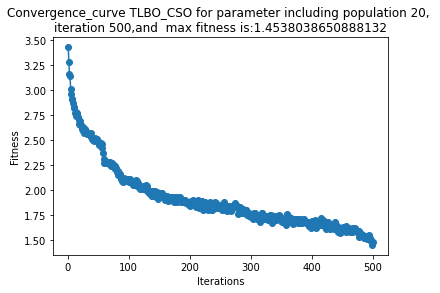

[7, 8, 10, 11, 12, 14, 18, 20, 21, 26, 27, 28, 30, 31, 32, 33, 36, 39, 40, 41, 42, 43, 44, 45, 48, 49, 50, 51, 53, 54, 55, 57, 61, 62, 64, 65, 68, 69, 73, 76, 77, 79, 80, 84, 86, 87, 90, 91, 92, 93, 94, 95, 96, 103, 105, 106, 107, 110, 111, 112, 113, 115, 116, 117, 123, 126, 127, 129, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142, 143, 145, 146, 153, 157, 160, 161, 162, 164, 166, 169, 170, 173, 177, 179, 180, 182, 183, 186, 187, 188, 189, 190, 191, 192, 193, 197, 198, 200, 201, 202, 203, 205, 206, 207, 208, 210, 211, 212]
117
[213, 500, 20, array([  7,   8,  10,  11,  12,  14,  18,  20,  21,  26,  27,  28,  30,
        31,  32,  33,  36,  39,  40,  41,  42,  43,  44,  45,  48,  49,
        50,  51,  53,  54,  55,  57,  61,  62,  64,  65,  68,  69,  73,
        76,  77,  79,  80,  84,  86,  87,  90,  91,  92,  93,  94,  95,
        96, 103, 105, 106, 107, 110, 111, 112, 113, 115, 116, 117, 123,
       126, 127, 129, 132, 133, 134, 135, 136, 137, 138, 139, 140, 142,
       143, 145, 1

In [ ]:
for i in range(5, 25, 5):
    col = []
    print(f"at poulation of {i}")
    for j in range(100, 600, 100):
        selected_features = []
        row = []
        print(f"at poulation of {i}")
        print(f" at iteration of {j}")
        data = TLBO_CSO(ackley, 0, 1, 213, i, j)
        fit, cost = data['p'], data['c']
        newPos = fit[0]
        for k in range(len(fit[0])):
            if newPos[k] == 1:
                selected_features.append(k)
        print(selected_features)
        arr = np.asarray(selected_features)
        print(len(selected_features))
        for o in range(1):
            row.append(213)
            row.append(j)
            row.append(i)
            row.append(arr)
            row.append(cost)
            row.append(len(selected_features))
        print(row)
        col.append(row)
        if j == 500:
            head = ["No. of features", "No. of iteration", "Population size", "Features Selected", "fitness value",
                    "Features number"]
            print(tabulate(col, headers=head, tablefmt="fancy_grid"))

